# Fruit classification with a CNN using Pytorch

In [1]:
from model import FNet
# import required modules
from utils import dataset
import torch 
import torch.tensor
import torch.nn as nn
import torchvision.transforms as transforms
from torch.autograd import Variable
from matplotlib import pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix 

#### Loading dataframe using dataset module 

In [2]:
df, df_train, df_test = dataset.create_and_load_meta_csv_df(dataset_path='../Data/fruits/', destination_path='./', randomize=True, split=0.8)

csv file for dataset is already present.
Dataframe is created.


#### Visualise data

In [3]:
df

,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,9992.0,9993.0,9994.0,9995.0,9996.0,9997.0,9998.0,9999.0,10000.0,label
2166,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,3
826,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,1
994,253,254,254,254,253,252,252,253,254,254,...,255,255,255,255,255,255,255,255,255,2
1936,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,4
1049,254,254,254,253,253,254,254,255,254,254,...,255,255,255,255,255,255,255,255,255,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1778,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,4
1291,254,254,254,254,254,254,253,252,254,254,...,255,255,255,255,255,255,255,255,255,2
1645,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,4
2371,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,3


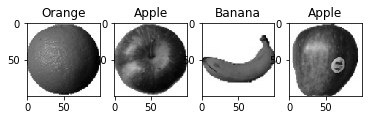

In [4]:
id_rand = np.random.randint(0, 2443, size = 4)
images = list()
labels = list()
fruit =["Apple","Banana","Orange","Pineapple","Strawberry"]

for x in id_rand:
    images.append(np.reshape(np.asarray(df.iloc[x][0:10000], dtype = np.float), (100, 100)))
    labels.append(df.iloc[x]['label'])
    
for c in range(len(images)):
    plt.figure(1) 
    plt.subplot(1,4,c+1) #create subplot for fruits images
    plt.imshow(images[c],cmap = plt.get_cmap('gray')) #show grayscale image of fruits which is store in .csv file
    plt.title(fruit[labels[c]])
    #print('Label :', labels[c]['label']) #print label of fruit   
    

#### Create a custom dataloader and apply Transforms

In [5]:
data_transforms = {
    'train': transforms.Compose([transforms.ToTensor()]),
    'test': transforms.Compose([transforms.ToTensor()]) }

image_datasets = {'train': dataset.ImageDataset(df_train, transform=data_transforms['train']), 
                'test': dataset.ImageDataset(df_test, transform=data_transforms['test'])}

In [6]:
dataloaders = { 'train_loader': torch.utils.data.DataLoader(image_datasets['train'],batch_size=7,shuffle=True),
                    'test_loader': torch.utils.data.DataLoader(image_datasets['test'],batch_size=7,shuffle=True) }

#### Neural Network, loss function and optimizer

In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
cnn=FNet().to(device) #create model called cnn
loss_func = nn.CrossEntropyLoss() #create Cross Entropy loss function
optimizer = torch.optim.SGD(cnn.parameters(), lr=0.001) #Use Adam optimizer with learning rate=0.001

epoch = 2 #no of epochs

In [8]:
cnn

FNet(
  (layer1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=20000, out_features=300, bias=True)
  (activ): ReLU()
  (regu): Dropout(p=0.1)
  (fc2): Linear(in_features=300, out_features=5, bias=True)
)

#### Training and Validation 

epoch :  1
0 	::: loss --- 1.1411939859390259
Accuracy of Train Data :  72.56908904810645
Accuracy of Validation Data :  71.37014314928425
100 	::: loss --- 0.6025460362434387
Accuracy of Train Data :  81.37154554759468
Accuracy of Validation Data :  78.93660531697341
200 	::: loss --- 0.5985532402992249
Accuracy of Train Data :  92.11873080859775
Accuracy of Validation Data :  91.20654396728017
epoch :  2
0 	::: loss --- 0.2858656942844391
Accuracy of Train Data :  92.32343909928352
Accuracy of Validation Data :  91.61554192229039
100 	::: loss --- 0.3262154757976532
Accuracy of Train Data :  94.47287615148413
Accuracy of Validation Data :  94.47852760736197
200 	::: loss --- 0.3246229588985443
Accuracy of Train Data :  95.95701125895599
Accuracy of Validation Data :  95.91002044989774


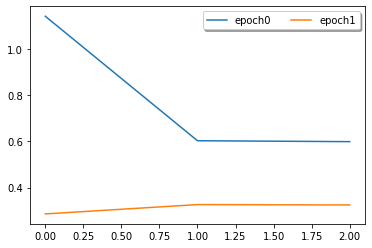

In [12]:
for i in range(epoch): 
    print('epoch : ',i+1) #print current epoch 
    num_times=0
    losses=[] #array to store loss after every 100 batches
    for j,[image1,label1] in enumerate(dataloaders['train_loader']): #get image and label from train_loader
        image = Variable(image1) 
        label = Variable(label1)

        optimizer.zero_grad()
        result = cnn.forward(image1) #use cnn model to get result
        loss = loss_func(result,label1) # use cross entrpy loss function to calculate loss
        loss.backward() #use back propagation
        optimizer.step()

        if j % 100 == 0: 
            print(j,'\t::: loss ---',loss.item()) #after 100 batches print loss
            losses.append(loss.item()) #append loss to array
            num_times += 1
        
        if j % 100 == 0:
            cnn.eval() #use cnn.eval() function to calculate accuracy 
            correct_train = correct_valid = 0 
            total_train = total_valid = 0

            # loop to calculate accuracy after each epoch of train_loader i.e test dataset
            for image2,label2 in dataloaders['train_loader']: 
                image2 = Variable(image2)
                result2 = cnn(image2) #use cnn to get result

                _,pred2 = torch.max(result2.data,1) # use to find max score of a neuron w.r.t. 1

                total_train += label2.size(0) 
                correct_train += (pred2 == label2).sum().item() #no of correct indentified labels 
                acc_train = (correct_train/total_train)*100 #calculate accuracy train dataset 

            print("Accuracy of Train Data : ",acc_train) #print accuracy of train dataset

            for image3,label3 in dataloaders['test_loader']: # loop to calculate accuracy after each epoch of test_loader i.e test dataset
                    image3 = Variable(image3)
                    result3 = cnn(image3) #use cnn to get result

                    _,pred3 = torch.max(result3.data,1) # use to find max score of a neuron w.r.t. 1

                    total_valid += label3.size(0) 
                    correct_valid += (pred3 == label3).sum().item() #no of correct indentified labels 
                    acc_valid = (correct_valid/total_valid)*100 #calculate accuracy of test dataset

            print("Accuracy of Validation Data : ",acc_valid) #print accuracy of test dataset
    plt.plot([i for i in range(num_times)],losses,label='epoch'+str(i)) #plot for loss and update after each epoch 
    plt.legend(loc=1,mode='expanded',shadow=True,ncol=2)


plt.show() #plt graph for loss 

We are using regularization to avoid overfitting also the model is selected such that it is not too complex. Regularization penalizes to avoid overfitting. Also complex model along with the relevent data also learns noise in the data to avoid doing so we are doing regularization and avoiding model to be too complex.

In [10]:
save = 1 #use 0 or 1 
if (save==True):
        torch.save(cnn.state_dict(),'cnn.ckpt')
        print("Model Saved")

Model Saved


#### Prediction and Confusion Matrix

In [11]:
batch_size=7 
comp_datasets = dataset.ImageDataset(df_test, transform=transforms.ToTensor()) #use ToTensor() transform on complete dataset
comp_data = torch.utils.data.DataLoader(comp_datasets,batch_size,shuffle=True) #load complete dataset using torch.utils.data.DataLoader and shuffle dataset

for w,[image1,label1] in enumerate(comp_data): #read one batch
    image = Variable(image1) 
    label = Variable(label1)
    result = cnn(image)  #use cnn model on each image of batch to find label
    _,pred = torch.max(result.data,1)  #predict result using max function,it given neuron with maximum output
    for h in range(0,batch_size):
        print('Label --- ',fruit[np.array(label[h])],'\t Prediction --- ',fruit[np.array(pred[h])]) #print original name and predicted name
    print('Confusion Matrix : \n',confusion_matrix(label, pred)) #Confusion matrix
    break
    

Label ---  Banana 	 Prediction ---  Banana
Label ---  Pineapple 	 Prediction ---  Strawberry
Label ---  Apple 	 Prediction ---  Strawberry
Label ---  Orange 	 Prediction ---  Orange
Label ---  Orange 	 Prediction ---  Orange
Label ---  Orange 	 Prediction ---  Orange
Label ---  Banana 	 Prediction ---  Banana
Confusion Matrix : 
 [[0 0 0 0 1]
 [0 2 0 0 0]
 [0 0 3 0 0]
 [0 0 0 0 1]
 [0 0 0 0 0]]
